# Main

In [1]:
# Mount into drive
from google.colab import drive
drive.mount("/content/grive")

Mounted at /content/grive


In [2]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [3]:
import random

# Set deterministic convolution algorithm
os.environ['CUDNN_DETERMINISTIC'] = 'true'

# Set deterministic cuDNN benchmark
os.environ['CUDNN_BENCHMARK'] = 'false'

# Set a fixed random seed
random.seed(42)

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn as nn


In [6]:
import torch.nn.functional as F

# Set fixed random seed
torch.manual_seed(42)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class SpatialPyramidPooling(nn.Module):
    def __init__(self, output_sizes):
        super(SpatialPyramidPooling, self).__init__()
        self.output_sizes = output_sizes

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        pooled_features = []

        for output_size in self.output_sizes:
            kh, kw = height // output_size, width // output_size
            ph, pw = height % output_size, width % output_size

            if ph == 0 and pw == 0:
                pooled_features.append(F.max_pool2d(x, kernel_size=(kh, kw), stride=(kh, kw)))
            else:
                x_padded = F.pad(x, (0, pw, 0, ph))
                pooled_features.append(F.max_pool2d(x_padded, kernel_size=(kh, kw), stride=(kh, kw)))

        x = torch.cat(pooled_features, dim=1)
        x = x.view(batch_size, -1)

        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(64),
            Swish(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(128),
            Swish(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            Swish(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(256),
            Swish(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, dilation=1),
            nn.BatchNorm2d(512),
            Swish(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SpatialPyramidPooling(output_sizes=[4, 4, 4])
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 48, 512),
            Swish(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            Swish(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            Swish(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [7]:
# Set a fixed random seed
torch.manual_seed(42)

# Define weight initialization
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

In [8]:
# Define your model
num_classes = 4
model = MyModel().to(device)
# Initialize the model
model.apply(weight_init)

MyModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Swish()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Swish()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Swish()
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

In [9]:
# Calculate the output size of feature extraction --this is just for check
model = MyModel()
dummy_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image
features_output = model.features(dummy_input)
num_features = features_output.size(1)
print("Input size before the first linear layer:", num_features)

Input size before the first linear layer: 24576


In [10]:
training_set = '/content/grive/MyDrive/images/filtered/mix_images'

In [11]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Set a fixed random seed for data loader
torch.manual_seed(42)

# Define the directory path and image transformations
train_directory = training_set
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the ImageFolder dataset
train_dataset = ImageFolder(train_directory, transform=image_transforms)


# Define the number of images to sample
n = 4 * 250

# Get the total number of images in the dataset
total_images = len(train_dataset)

# Create batch size
batch_size = 16

# Create the DataLoader for the sampled dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [12]:
# Get the class labels and their corresponding indixes
class_labels = train_dataset.classes
class_indices = train_dataset.class_to_idx

# Mapping between class labels and indixes
for label, index in class_indices.items():
    print(f"Class Label: {label}, Class Index: {index}")


Class Label: EOSINOPHIL, Class Index: 0
Class Label: LYMPHOCYTE, Class Index: 1
Class Label: MONOCYTE, Class Index: 2
Class Label: NEUTROPHIL, Class Index: 3


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# Set a fixed random seed for data loader
torch.manual_seed(42)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the criterion to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = criterion.to(device)

# Move the model to the appropriate device
model = model.to(device)

# Training loop
num_epochs = 3
best_loss = float('inf')
patience = 10
counter = 0

# Create the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

start = time.time()
for epoch in range(num_epochs):
    # Accumulate gradients over multiple batches
    total_loss = 0.0
    accumulation_steps = 4
    correct_predictions = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        batch_images = batch_images.to(device)  # Send the input tensor to the appropriate device
        batch_labels = batch_labels.to(device)  # Send the input tensor to the appropriate device

        optimizer.zero_grad()

        # Perform forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        total_loss += loss.item()

        # Perform backward pass
        loss.backward()

        # Perform gradient accumulation
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        # Calculate the accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == batch_labels).sum().item()

    total_loss /= len(train_loader)


    # Update the learning rate scheduler
    scheduler.step(total_loss)

    # Epoch information and Calculate the accuracy
    accuracy = correct_predictions / len(train_loader.dataset) * 100
    print(f"Epoch {epoch + 1}: Loss: {total_loss}", f"Training accuracy: {accuracy:.2f}%")

    # Check for early stopping
    if total_loss < best_loss:
        best_loss = total_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


end = time.time()
print(f"Training time: {end - start}")


In [ ]:
# Save model
torch.save(model.state_dict(), 'save_model.pht')

In [13]:
# Load the model
model_upload = torch.load('/content/grive/MyDrive/model_objects/filtered/mix_images_6th_0_swish.pht', map_location=device)

# Create an instance of MyModel
model = MyModel()

# Copy the loaded weights and biases to the model
model.load_state_dict(model_upload)

# Move the model to the appropriate device
model = model.to(device)

In [ ]:
# Train set prediction
from tensorflow.python.ops.math_ops import truncate_div
appended_preds = torch.tensor([]).to(device)
appended_true = torch.tensor([]).to(device)

# Predict on the test set
with torch.no_grad():
    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        softmax = nn.Softmax(dim=1)
        probabilities = softmax(outputs)
        _, predicted_indices = torch.max(probabilities, dim=1)
        appended_preds = torch.cat((appended_preds, predicted_indices), dim=0)
        appended_true = torch.cat((appended_true, batch_labels.to(device)), dim=0)


# Train set accuracy
total = len(appended_true)
correct = (appended_preds == appended_true).sum().item()
accuracy = correct / total * 100

accuracy

# Test

In [16]:
test_set = '/content/grive/MyDrive/images/test_set'

# Test set accuracy
test_directory = test_set
test_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the ImageFolder dataset
test_dataset = ImageFolder(test_directory, transform=test_image_transforms)

import random

# Define the number of images to sample
n = 4 * 250

# Get the total number of images in the dataset
test_total_images = len(test_dataset)


# Generate random indices to sample from the dataset
random_indices = random.sample(range(test_total_images), n)

# Create the DataLoader
batch_size = 16

# Create the DataLoader for the sampled dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Get the class labels and their corresponding indixes
class_labels = test_dataset.classes
class_indices = test_dataset.class_to_idx

for label, index in class_indices.items():
    print(f"Class Label: {label}, Class Index: {index}")


Class Label: EOSINOPHIL, Class Index: 0
Class Label: LYMPHOCYTE, Class Index: 1
Class Label: MONOCYTE, Class Index: 2
Class Label: NEUTROPHIL, Class Index: 3


In [17]:
# Test set prediction
test_appended_preds = torch.tensor([]).to(device)
test_appended_true = torch.tensor([]).to(device)

# Predict on the test set
with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        softmax = nn.Softmax(dim=1)
        probabilities = softmax(outputs)
        _, predicted_indices = torch.max(probabilities, dim=1)
        test_appended_preds = torch.cat((test_appended_preds, predicted_indices), dim=0)
        test_appended_true = torch.cat((test_appended_true, batch_labels.to(device)), dim=0)


# Test set accuracy
test_total = len(test_appended_true)
test_correct = (test_appended_preds == test_appended_true).sum().item()
test_accuracy = test_correct / test_total * 100

test_accuracy

26.5

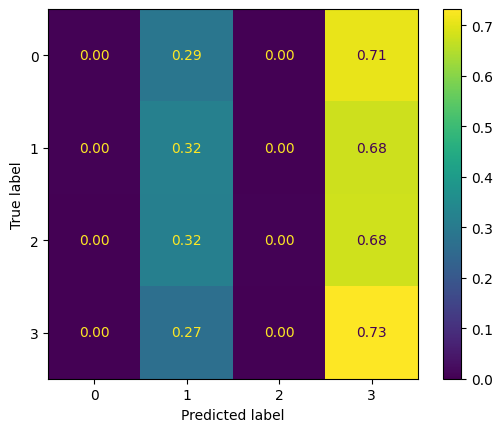

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Define the class labels
class_labels = ['0', '1', '2', '3']

# Convert to numpy
predicted = test_appended_preds.cpu().numpy()
true = test_appended_true.cpu().numpy()

# Confusion matrix with normalization
cm = confusion_matrix(true, predicted, normalize='true')

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cm_display.plot(include_values=True, values_format='.2f')

plt.show()



# extract images after layers

In [19]:
from PIL import Image
import torchvision.transforms as transforms
import os

device = torch.device('cpu')  # Specify the device as CPU

# Move the model to the specified device
model.to(device)

# Define the target layers whose intermediate images you want to visualize
target_layers = [model.features[0], model.features[13]]

# Define a dictionary to store the intermediate images
intermediate_images = {}

# Define a hook function to capture the intermediate images
def hook_fn(module, input, output):
    intermediate_images[str(module)] = output.detach()

# Register the hook for each target layer
for layer in target_layers:
    layer.register_forward_hook(hook_fn)

# Load and preprocess the image
image_path = '/content/grive/MyDrive/images/filtered/BASE/EOSINOPHIL/_0_5579.jpeg'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Move the input image tensor to the specified device
image = preprocess(image).unsqueeze(0).to(device)

# Pass the image through the model to get the output
output = model(image)

# Access the intermediate images from the dictionary
for layer_name, image in intermediate_images.items():
    # Split the tensor into separate channels
    image_channels = torch.split(image, 1, dim=1)

    # Specify the output directory and filename
    output_directory = "/content/grive/MyDrive/images/intermediate_images_initial_model"
    os.makedirs(output_directory, exist_ok=True)
    output_filename = f"{layer_name}_result_image.jpg"
    output_path = os.path.join(output_directory, output_filename)

    # Convert each channel to a PIL image and save it
    for i, channel in enumerate(image_channels):
        channel_pil = transforms.ToPILImage()(channel.squeeze().cpu())
        channel_pil.save(output_path)
